In [1]:
# NB: the recommended way to run isoclassify is through the command-line interface (CLI)
# using examples such as given in examples/examples.csv (see README)
# below is an example to run isoclassify from ipython, which requires some hacking by 
# pre-defining functions but allows direct interaction with posteriors. 

In [2]:
# required packages
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os 
import copy
import glob
import h5py,pdb

import numpy as np
from matplotlib import pylab as plt
import pandas as pd
import astropy.units as units
from astropy.coordinates import SkyCoord
#from dustmaps.bayestar import BayestarWebQuery
import mwdust

from isoclassify.direct import classify as classify_direct
from isoclassify.grid import classify as classify_grid
from isoclassify import DATADIR

In [3]:
# load models
fn = os.path.join(DATADIR,'mesa.h5')
modfile = h5py.File(fn,'r', driver='core', backing_store=False)
model = {'age':np.array(modfile['age']),\
'mass':np.array(modfile['mass']),\
'feh_init':np.array(modfile['feh']),\
'feh':np.array(modfile['feh_act']),\
'teff':np.array(modfile['teff']),\
'logg':np.array(modfile['logg']),\
'rad':np.array(modfile['rad']),\
'lum':np.array(modfile['rad']),\
'rho':np.array(modfile['rho']),\
'dage':np.array(modfile['dage']),\
'dmass':np.array(modfile['dmass']),\
'dfeh':np.array(modfile['dfeh']),\
'eep':np.array(modfile['eep']),\
'bmag':np.array(modfile['bmag']),\
'vmag':np.array(modfile['vmag']),\
'btmag':np.array(modfile['btmag']),\
'vtmag':np.array(modfile['vtmag']),\
'gmag':np.array(modfile['gmag']),\
'rmag':np.array(modfile['rmag']),\
'imag':np.array(modfile['imag']),\
'zmag':np.array(modfile['zmag']),\
'jmag':np.array(modfile['jmag']),\
'hmag':np.array(modfile['hmag']),\
'kmag':np.array(modfile['kmag']),\
'bpmag':np.array(modfile['bpmag']),\
'gamag':np.array(modfile['gamag']),\
'rpmag':np.array(modfile['rpmag']),\
'fdnu':np.array(modfile['fdnu']),\
'avs':np.zeros(len(np.array(modfile['gamag']))),\
'dis':np.zeros(len(np.array(modfile['gamag'])))}

#ebf.read(os.path.join(DATADIR,'mesa.ebf'))
# prelims to manipulate some model variables (to be automated soon ...)
#pdb.set_trace()
model['rho'] = np.log10(model['rho'])
model['lum'] = model['rad']**2*(model['teff']/5777.)**4
# next line turns off Dnu scaling relation corrections
model['fdnu'][:]=1.
model['avs']=np.zeros(len(model['teff']))
model['dis']=np.zeros(len(model['teff']))

In [4]:
# define class that contains observables
x = classify_grid.obsdata()

In [5]:
# add [Teff, logg, FeH] and [sigma_Teff, sigma_logg, sigma_FeH] 
x.addspec([5777.,4.44,0.0],[60.,0.07,0.04])

teff 257001
feh 14977
number of models used within non-phot obsconstraints: 14977
number of models after phot constraints: 14977
----
teff 5768.624354788214 58.10091430997545 60.15133990556478
logg 4.43697021849073 0.05299628935991674 0.06306437288384004
feh -0.009671365982173219 0.037906422093616984 0.040483903258584086
rad 0.9820724068131902 0.07312319134061085 0.05717691947618131
mass 0.9845562689011795 0.025677085855159598 0.025857090742937072
rho 1.002592028231527 0.20084883201961667 0.19387247944371855
lum 0.9682258048311181 0.15924542041454393 0.12472827025199218
age 3.9413932408048744 2.4405568042075956 2.285348147636607


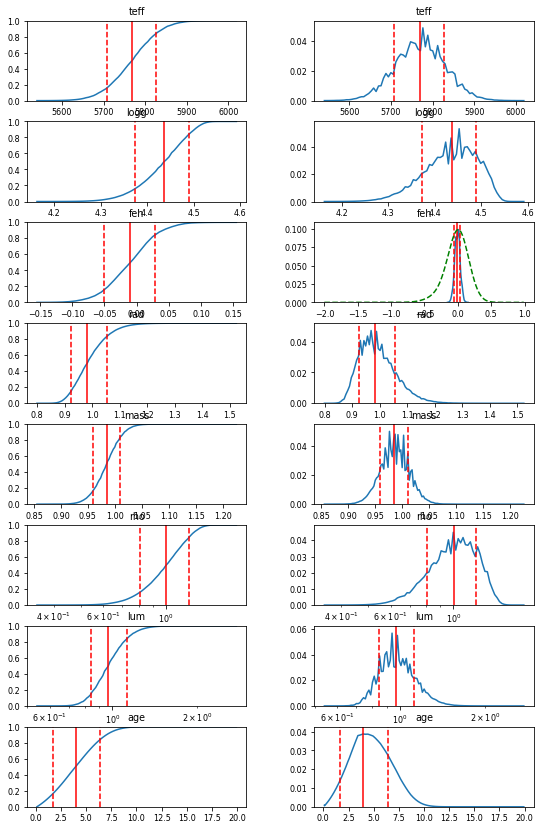

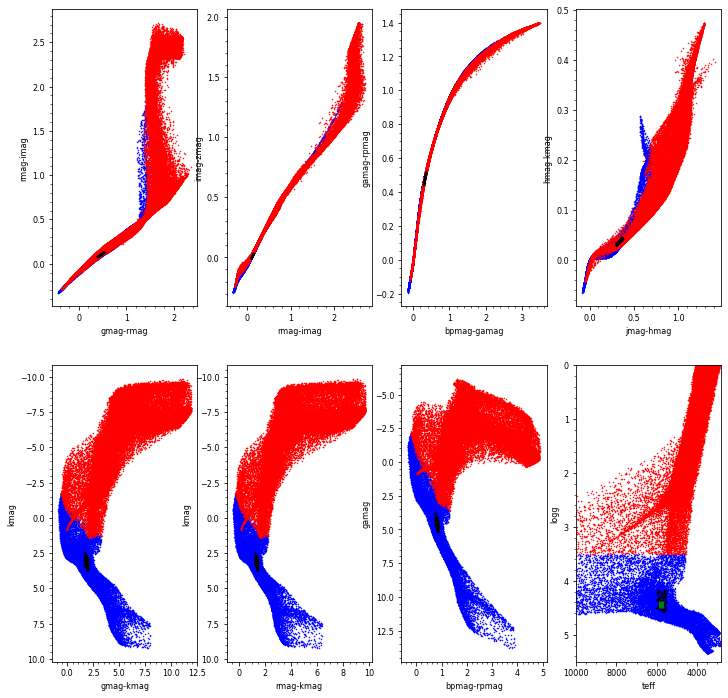

In [6]:
# perform classification based on those inputs
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,band='kmag')

In [7]:
# print results for radius
paras.rad,paras.radep,paras.radem

(0.9820724068131902, 0.07312319134061085, 0.05717691947618131)

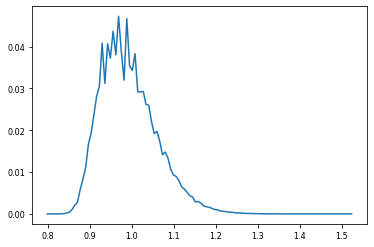

In [8]:
# plot the radius posterior
plt.plot(paras.radpx,paras.radpy)

In [9]:
# now let's add some more observables, e.g. a parallax 
x.addplx(0.07,0.007)

In [10]:
# and some JHK photometry
x.addjhk([4.38,4.04,4.00],[0.03,0.03,0.03])

In [11]:
# using photometry requires some treatment of reddening and extinction. the following functions
# required for this

def query_dustmodel_coords(ra,dec,dust):
    if dust == 'allsky':
        reddenMap = mwdust.Combined19()
        ext = extinction('green19')
    if dust == 'green19':
        reddenMap = mwdust.Green19()
        ext = extinction('green19')
    if dust == 'zero':
        reddenMap = mwdust.Zero()
        ext = extinction('cardelli')
    if dust == 'none':
        reddenMap = 0
        ext = extinction('cardelli')
        print('Fitting for reddening.')
        return reddenMap,ext

    sightLines = SkyCoord(ra*units.deg,dec*units.deg,frame='icrs')
    sightLines = sightLines.transform_to('galactic')

    PACKAGEDIR='../isoclassify/'

    distanceSamples = np.loadtxt(f"{PACKAGEDIR}/data/distance-samples-green19.txt",delimiter=',')*1000.

    reddenContainer = reddenMap(sightLines.l.value,sightLines.b.value,distanceSamples/1000.)

    del reddenMap # To clear reddenMap from memory

    dustModelDF = pd.DataFrame({'ra': [ra], 'dec': [dec]})

    for index in range(len(reddenContainer)):
        dustModelDF['av_'+str(round(distanceSamples[index],6))] = reddenContainer[index]

    return dustModelDF,ext

def extinction(law):

    PACKAGEDIR='../isoclassify/'
    if (law == 'cardelli'):
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-cardelli-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)

    if (law == 'schlafly11'):
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-schlafly11-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)

    if (law == 'schlafly16'):
        # see http://argonaut.skymaps.info/usage under "Gray Component". this is a lower limit.
        grayoffset=0.063
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-schlafly16-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)+grayoffset

    if (law == 'green19'):
        out = {}

        with open(f"{PACKAGEDIR}/data/extinction-vector-green19-iso.txt") as f:

            for line in f:
                (key,val) = line.split(',')
                out[key] = float(val)
    return out


In [12]:
# if we don't want to use a reddening map, isoclassify fits for Av. However, we need to 
# define an extinction law
ext = extinction('cardelli')

teff 257001
feh 14977
number of models used within non-phot obsconstraints: 14977
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
number of models incl reddening: 1947010
number of models after phot constraints: 1946903
----
teff 5773.058926042997 58.24354415388734 58.05324867343006
logg 4.422174612776466 0.05084105989811327 0.05360106550532606
feh -0.006734747409025113 0.036545952557266365 0.04169167136180368
rad 1.000246766778209 0.06254909647888751 0.055182064316577684
mass 0.9856915426007612 0.02636117118808523 0.025945726567004224
rho 0.9528780397266335 0.17974941968900027 0.15916538937262614
lum 1.0039831371047487 0.14186466

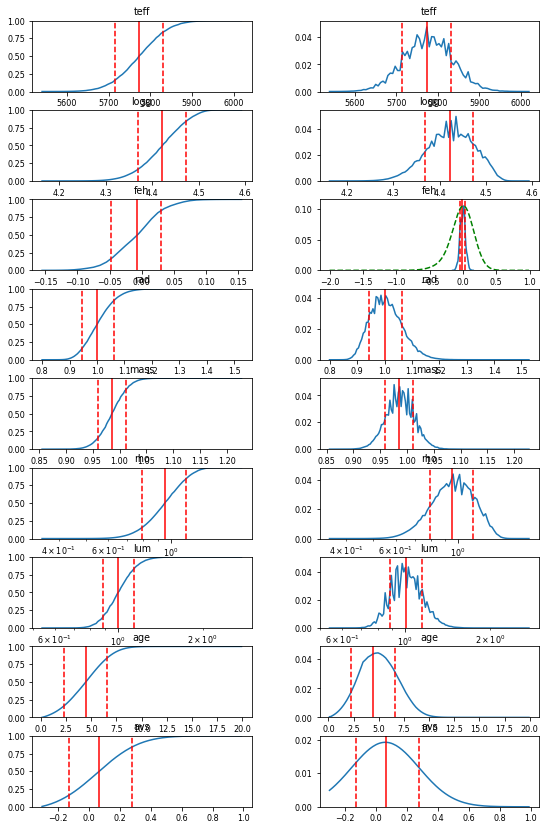

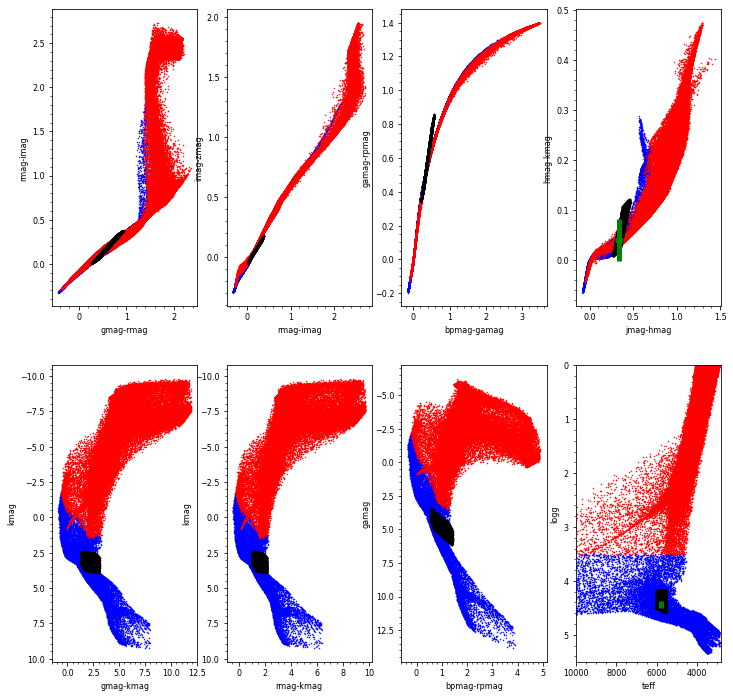

In [13]:
# perform classification
paras = classify_grid.classify(input=x, model=model, dustmodel=0,plot=1,ext=ext,band='kmag')

In [42]:
# if we want to use a reddening map, we'll need to add coordinates
x.addcoords(243.9052932171665,-08.3694394)

In [44]:
# and define a dustmodel. this is the "allsky" model by Bovy
dustmodel = query_dustmodel_coords(x.ra,x.dec,'allsky')

teff 257001
feh 14977
number of models used within non-phot obsconstraints: 14977
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
number of models incl reddening: 1947010
number of models after phot constraints: 1946903
----
teff 5773.058926042997 58.24354415388734 58.05324867343006
logg 4.422174612776466 0.05084105989811327 0.05360106550532606
feh -0.006734747409025113 0.036545952557266365 0.04169167136180368
rad 1.000246766778209 0.06254909647888751 0.055182064316577684
mass 0.9856915426007612 0.02636117118808523 0.025945726567004224
rho 0.9528780397266335 0.17974941968900027 0.15916538937262614
lum 1.0039831371047487 0.14186466

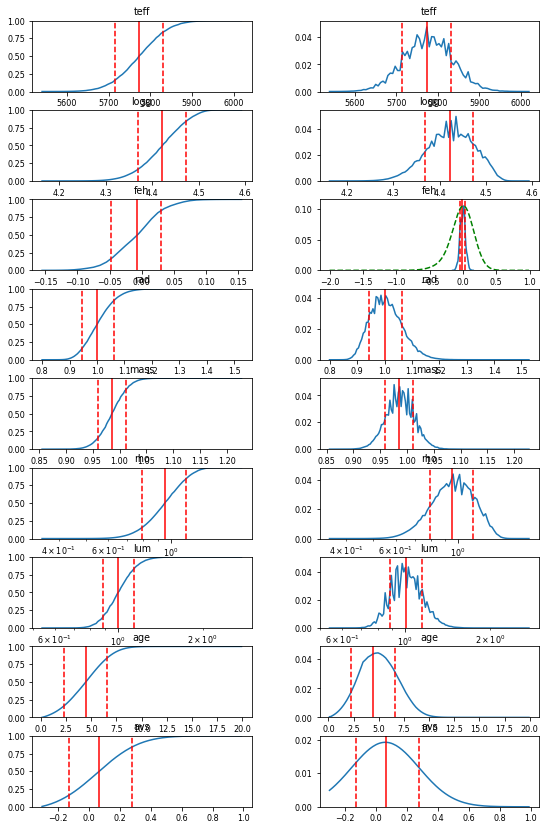

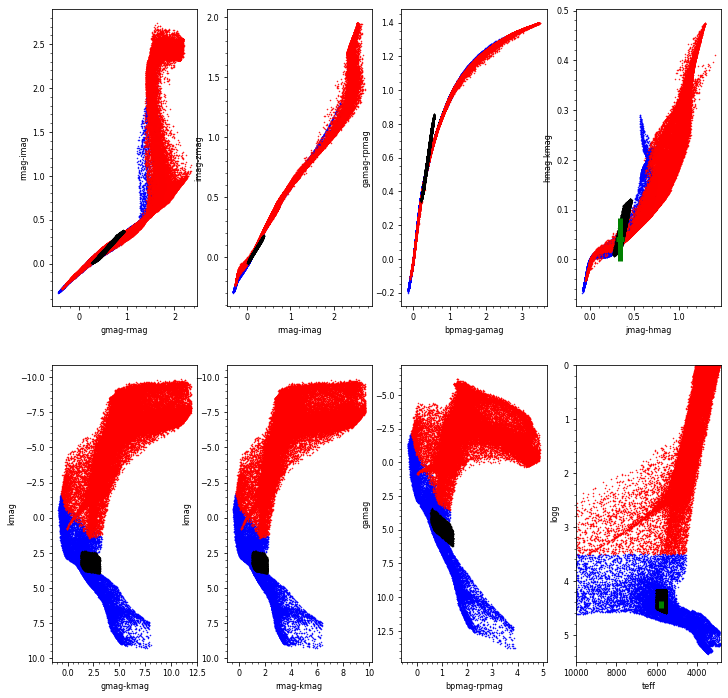

In [45]:
# redo fit, this time using the dustmodel
paras = classify_grid.classify(input=x, model=model, dustmodel=dustmodel,plot=1,ext=ext,band='kmag')